In [170]:
import numpy as np
import matplotlib.pyplot as plt

In [171]:
"""
Idea is to index a 2D array using some 1D curve. Thus, there is an index mapping from each (x,y)->ind
Further, each site also has an adjancency set. This is the set of indices that are coupled to the site by an FM interaction
The model is defined using a 1xN field matrix and an NxN coupling matrix. The coupling matrix is sparse. N = LxW
"""



def index_map(x, y, L):
    if x>L or y>L: return None
    return x*L + y



def square_lattice_dictionary(L):
    
    ind_dict = {}
    adj_ind = {}
    
    for x in range(L):
        for y in range(L):
            ind_0 = index_map(x,y,L)

            adjs = [index_map(x,(y+1)%L, L), index_map(x,(y-1)%L, L), index_map((x+1)%L,y, L), index_map((x-1)%L,y, L)]

            ind_dict[ind_0] = (x,y)
            adj_ind[ind_0] = adjs
    return ind_dict, adj_ind

ind_dict, adj_ind = square_lattice_dictionary(L)

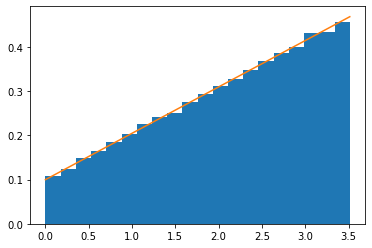

In [172]:
def random_custDist(a,b,custDist,size=None, nControl=10**6):
    #genearte a list of size random samples, obeying the distribution custDist
    #suggests random samples between x0 and x1 and accepts the suggestion with probability custDist(x)
    #custDist noes not need to be normalized. Add this condition to increase performance. 
    #Best performance for max_{x in [x0,x1]} custDist(x) = 1
    samples=[]
    nLoop=0
    
    low = 0
    high = (np.sqrt(a**2 + 2*b) - a)/b
    
    while len(samples)<size and nLoop<nControl:
        x=np.random.uniform(low=low,high=high)
        prop=custDist(x, a, b)
        assert prop>=0 and prop<=1
        if np.random.uniform(low=0,high=1) <=prop:
            samples += [x]
        nLoop+=1
    return samples

#call
a=0.1
b=0.105
def custDist(x, a, b):
    return a + b*x
samples=random_custDist(a,b,custDist=custDist,size=100000)
#print(samples)

plt.hist(samples, density=True, bins = 20)

x = np.linspace(0, (np.sqrt(a**2 + 2*b) - a)/b, 1000)

plt.plot(x, custDist(x, a, b))

In [150]:
def update_adjacency_J_ij(adj_ind, i, j):
    #Updates adjaceny set of i with that of j
    #Also deletes index from the adjacency list of other indices
    adj_i = adj_ind[i]
    adj_j = adj_ind[j]
    
    adj_i_new = list(set(adj_i+adj_j))
    adj_i_new = list(set(adj_i_new)-set([i, j]))
    adj_ind[i] = adj_i_new
    adj_ind[j] = []
    
    for k in adj_i_new:
        adj_ind[k] = list(set(adj_ind[k]+[i])-set([j]))
        
    return None

def update_adjacency_h(adj_ind, i):
    #Updates adjacency set of every element in adj(i) with adj(i)
    #Also deletes index i from adj(k) for all k in adj(i)
    adj_i = adj_ind[i]
    
    for k in adj_ind[i]:
        adj_ind[k] = list(set(adj_ind[k]+adj_i)-set([i]))
        
    adj_ind[i] = []
    return None
    

In [238]:
L = 40
a_vals = np.array([0.1])#np.arange(0.05, 0.2, 0.02)
b_vals = np.array([0.1])#np.arange(0.1,0.3,0.03)

#h_vals = np.array(random_custDist(a,b,custDist=custDist,size=L*L))
#J_ij_vals = np.zeros(shape=(L*L,L*L))

#for ind in range(L*L):
#    J_ij_vals[ind, adj_ind[ind]] = np.exp(-np.random.exponential(size=(1,len(adj_ind[0]))))

#J_ij_vals = 0.5*(J_ij_vals+J_ij_vals.T)

In [241]:
steps = 1500
Gamma_array = np.zeros(shape=(len(a_vals), len(b_vals), steps))


for l, a in enumerate(a_vals):
    for m, b in enumerate(b_vals):
        
        ind_dict, adj_ind = square_lattice_dictionary(L)
        
        J_ij_vals = np.zeros(shape=(L*L,L*L))

        for ind in range(L*L):
            J_ij_vals[ind, adj_ind[ind]] = np.exp(-np.random.exponential(size=(1,len(adj_ind[0]))))

        J_ij_vals = 0.5*(J_ij_vals+J_ij_vals.T)
        h_vals = np.array(random_custDist(a,b,custDist=custDist,size=L*L))
        Omega_0 = max(h_vals.max(), 2*J_ij_vals.max())
        for step in range(steps):
    
            if step%500 == 0: print ("Step: "+str(step)+"/"+str(steps))
            Omega = max(h_vals.max(), 2*J_ij_vals.max())
            Gamma_array[l,m,step] = (np.log(Omega_0/Omega))

            if Omega == 2*J_ij_vals.max():
                """
                Strongest term is an Ising coupling -> Renormalizes to a field given by h_i * h_j/J_ij
                Delete one of the elements (say h_i), shortening h_vals
                Update adjacency of j to include both adj(i) and adj(j)
                Set new Jnew_jk = max (J_jk, J_ik)
                Delete the corresponding row and column in J_ij (J_i* and J*i) and set the adjacency of i to []
                """
                i_list, j_list = np.asarray(J_ij_vals == J_ij_vals.max()).nonzero()
                i = i_list[0]
                j = j_list[0]

                h_vals[i] = h_vals[i]*h_vals[j]/Omega    #Might need to include a factor of 2 here since we are symmetrizing later
                h_vals[j] = 0

                update_adjacency_J_ij(adj_ind, i, j)

                J_ij_vals[i,adj_ind[i]] = np.maximum(J_ij_vals[i, adj_ind[i]], J_ij_vals[j, adj_ind[i]])

                J_ij_vals[j,:] = 0
                J_ij_vals[:,j] = 0

                J_ij_vals = 0.5*(J_ij_vals+J_ij_vals.T)

            elif Omega == h_vals.max():
                """
                """
                i = np.where(h_vals == h_vals.max())[0][0]
                adj_i = adj_ind[i]
                J_ij_new = np.einsum('j,k->jk', J_ij_vals[adj_i, i], J_ij_vals[i, adj_i])/Omega

                J_ij_vals[adj_i, :][:, adj_i] = np.maximum(J_ij_new, J_ij_vals[adj_i,:][:, adj_i])

                h_vals[i] = 0

                J_ij_vals[i,:] = 0
                J_ij_vals[:,i] = 0

                update_adjacency_h(adj_ind, i)

Step: 0/1500
Step: 500/1500


C:\Users\tsgau\AppData\Local\Temp\ipykernel_7496\3228837526.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  Gamma_array[l,m,step] = (np.log(Omega_0/Omega))
C:\Users\tsgau\AppData\Local\Temp\ipykernel_7496\3228837526.py:36: RuntimeWarning: invalid value encountered in double_scalars
  h_vals[i] = h_vals[i]*h_vals[j]/Omega    #Might need to include a factor of 2 here since we are symmetrizing later


Step: 1000/1500


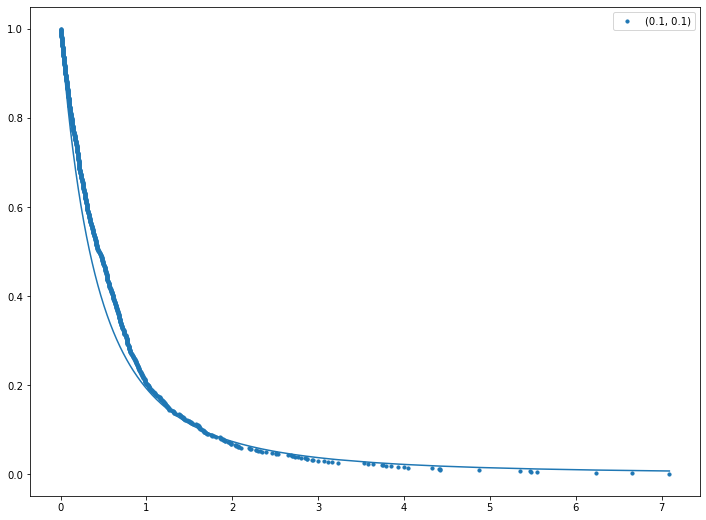

In [242]:
n_array = (- np.arange(steps)+(L*L))/(L*L)
plt.figure(figsize=(12, 9))
for l, a in enumerate(a_vals):
    for m, b in enumerate(b_vals):
        plt.scatter(Gamma_array[l,m,:],  n_array, s=10, label="("+str(a)+', '+str(b)+")")
plt.plot(Gamma_array[0,0,:], (Gamma_array[0,0,:]+1)**(-1/0.42))
plt.legend()

In [51]:
class Site:
    def __init__(self, ind, adj):
        self.ind = ind
        self.adj = adj
        return  None
    
    def add_adj_ind(self, adj_ext):
        self.adj = list(set(self.adj+adj_ext))
        return None
    
    def rm_adj_ind(self, adj_rm):
        self.adj = list(set(self.adj)-set(adj_rm))
        return None


In [94]:
L = 3

lat_ind, adj_ind = square_lattice_dictionary(L)

J_ij_vals = np.zeros(shape=(L*L,L*L))
h_vals = np.random.uniform(size=(L*L))

for ind in range(L*L):
    J_ij_vals[ind, adj_ind[ind]] = np.random.uniform(size=(1,len(adj_ind[ind])))
    
J = (J_ij_vals+ J_ij_vals.T)/2

Omega = h_vals.max()
#i,j = np.asarray(J == J.max()).nonzero()
i = np.where(h_vals == h_vals.max())[0][0]
i

7

In [95]:
adj_i = adj_ind[i]
J_ij_new = np.einsum('j,k->jk', J[adj_i, i], J[i, adj_i])/Omega

In [96]:
J_ij_new

array([[0.40231992, 0.30348908, 0.38446669, 0.56169656],
       [0.30348908, 0.22893627, 0.29002154, 0.42371448],
       [0.38446669, 0.29002154, 0.36740571, 0.53677088],
       [0.56169656, 0.42371448, 0.53677088, 0.78420931]])

In [109]:
J[adj_i, :][:,adj_i]

array([[0.        , 0.60183954, 0.        , 0.        ],
       [0.60183954, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.77348444],
       [0.        , 0.        , 0.77348444, 0.        ]])

In [113]:
np.maximum(J_ij_new, J[adj_i, :][:,adj_i])

array([[0.40231992, 0.60183954, 0.38446669, 0.56169656],
       [0.60183954, 0.22893627, 0.29002154, 0.42371448],
       [0.38446669, 0.29002154, 0.36740571, 0.77348444],
       [0.56169656, 0.42371448, 0.77348444, 0.78420931]])

In [111]:
A = np.array([[1,2,3],[4,5,6],[7,8,9]])

ind_a = [0,2]

A[ind_a, :][:, ind_a]

array([[1, 3],
       [7, 9]])

In [112]:
A

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])